In [6]:
import ml_loader as ml #import library
import numpy as np # linear algebra
import pandas as pd

In [7]:
df = ml.load_data('Telco_customer_churn.xlsx')  
print(df.head())

   CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  California  Los Angeles     90015   

                 Lat Long   Latitude   Longitude  Gender  ...        Contract  \
0  33.964131, -118.272783  33.964131 -118.272783    Male  ...  Month-to-month   
1   34.059281, -118.30742  34.059281 -118.307420  Female  ...  Month-to-month   
2  34.048013, -118.293953  34.048013 -118.293953  Female  ...  Month-to-month   
3  34.062125, -118.315709  34.062125 -118.315709  Female  ...  Month-to-month   
4  34.039224, -118.266293  34.039224 -118.266293    Male  ...  Month-to-month   

  Paperless Billing             Payment Method  Monthly Charges Tota

In [8]:
# Print the column names to check for any discrepancies
print(df.columns)

# Check for missing values
print(df.isnull().sum())


# Handle missing values in 'Churn Reason'
# Option 1: Drop the column if it's not needed
df.drop(columns=['Churn Reason'], inplace=True)

# Option 2: Impute missing values with the mode (most frequent value) of 'Churn Reason'
# df['Churn Reason'] = df['Churn Reason'].fillna(df['Churn Reason'].mode()[0])

# Alternatively, you could create a new feature to mark missing values
# df['Churn Reason Missing'] = df['Churn Reason'].isnull().astype(int)

# Impute numerical columns with median (assigning the result to the column)
df['Monthly Charges'] = df['Monthly Charges'].fillna(df['Monthly Charges'].median())

# Impute categorical columns with mode (assigning the result to the column)
df['Contract'] = df['Contract'].fillna(df['Contract'].mode()[0])

# Alternatively, drop rows with missing values in the target variable
df.dropna(subset=['Churn Label'], inplace=True)  # Drop rows where target variable is missing

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')
CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Servic

In [9]:
# Check for non-numeric values in columns that should be numeric
columns_to_check = ['Monthly Charges', 'Tenure Months', 'Total Charges']

for col in columns_to_check:
    # Check for rows that can't be converted to numeric (they will throw errors)
    invalid_rows = df[~df[col].apply(pd.to_numeric, errors='coerce').notnull()]
    print(f"Non-numeric values in {col}:\n", invalid_rows)


Non-numeric values in Monthly Charges:
 Empty DataFrame
Columns: [CustomerID, Count, Country, State, City, Zip Code, Lat Long, Latitude, Longitude, Gender, Senior Citizen, Partner, Dependents, Tenure Months, Phone Service, Multiple Lines, Internet Service, Online Security, Online Backup, Device Protection, Tech Support, Streaming TV, Streaming Movies, Contract, Paperless Billing, Payment Method, Monthly Charges, Total Charges, Churn Label, Churn Value, Churn Score, CLTV]
Index: []

[0 rows x 32 columns]
Non-numeric values in Tenure Months:
 Empty DataFrame
Columns: [CustomerID, Count, Country, State, City, Zip Code, Lat Long, Latitude, Longitude, Gender, Senior Citizen, Partner, Dependents, Tenure Months, Phone Service, Multiple Lines, Internet Service, Online Security, Online Backup, Device Protection, Tech Support, Streaming TV, Streaming Movies, Contract, Paperless Billing, Payment Method, Monthly Charges, Total Charges, Churn Label, Churn Value, Churn Score, CLTV]
Index: []

[0 row

In [10]:
# Step 1: Replace non-numeric values with NaN in the 'Total Charges' column
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

# Step 2: Check for missing values (NaNs) in 'Total Charges' after coercion
print(df['Total Charges'].isnull().sum())  # Check how many NaN values exist now

# Step 3: Handle NaNs - Impute missing values with median or remove rows with NaN
df['Total Charges'] = df['Total Charges'].fillna(df['Total Charges'].median())

# Step 4: Verify the data again
print(df['Total Charges'].isnull().sum())  # Ensure there are no NaN values left


11
0


In [11]:
# Check for missing values
print(df.isnull().sum())


CustomerID           0
Count                0
Country              0
State                0
City                 0
Zip Code             0
Lat Long             0
Latitude             0
Longitude            0
Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn Label          0
Churn Value          0
Churn Score          0
CLTV                 0
dtype: int64


In [12]:
# Cross-tabulation for categorical features
churn_contract = pd.crosstab(df['Contract'], df['Churn Label'])
print(churn_contract)

# Correlation matrix for numerical features
corr_matrix = df[['Monthly Charges', 'Tenure Months', 'Total Charges', 'Churn Score', 'CLTV']].corr()
print(corr_matrix)


Churn Label       No   Yes
Contract                  
Month-to-month  2220  1655
One year        1307   166
Two year        1647    48
                 Monthly Charges  Tenure Months  Total Charges  Churn Score  \
Monthly Charges         1.000000       0.247900       0.650864     0.133754   
Tenure Months           0.247900       1.000000       0.825464    -0.224987   
Total Charges           0.650864       0.825464       1.000000    -0.123948   
Churn Score             0.133754      -0.224987      -0.123948     1.000000   
CLTV                    0.098693       0.396406       0.341723    -0.079782   

                     CLTV  
Monthly Charges  0.098693  
Tenure Months    0.396406  
Total Charges    0.341723  
Churn Score     -0.079782  
CLTV             1.000000  


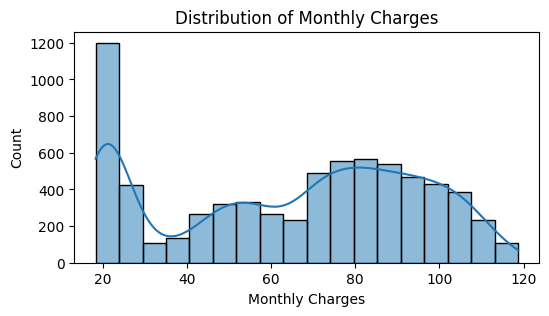

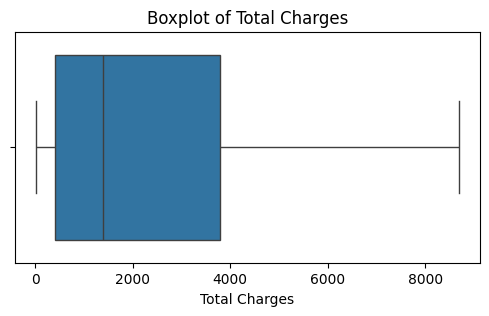

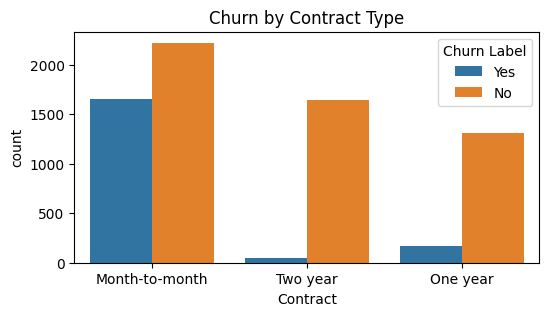

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogram for 'Monthly Charges'
plt.figure(figsize=(6, 3))
sns.histplot(df['Monthly Charges'], kde=True)
plt.title('Distribution of Monthly Charges')
plt.show()

# Boxplot to identify outliers in 'Total Charges'
plt.figure(figsize=(6, 3))
sns.boxplot(x=df['Total Charges'])
plt.title('Boxplot of Total Charges')
plt.show()

# Bar plot for 'Contract' vs 'Churn Label'
plt.figure(figsize=(6, 3))
sns.countplot(x='Contract', hue='Churn Label', data=df)
plt.title('Churn by Contract Type')
plt.show()


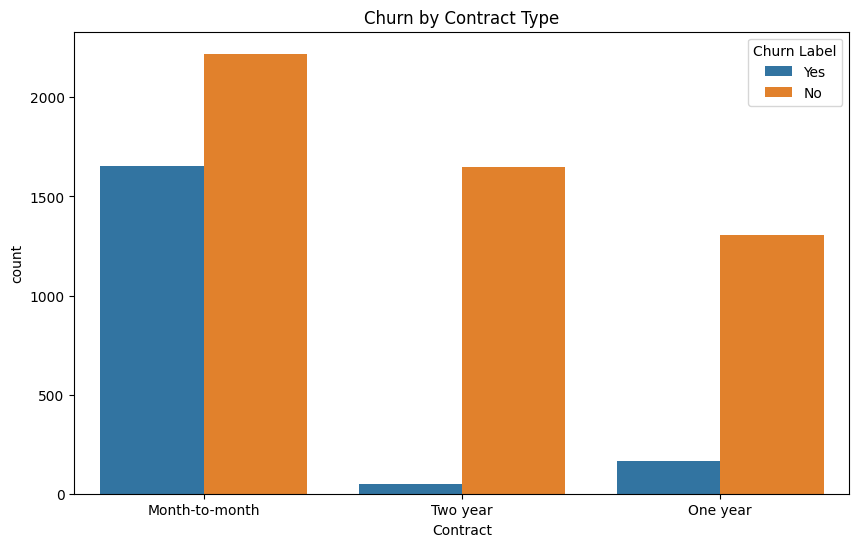

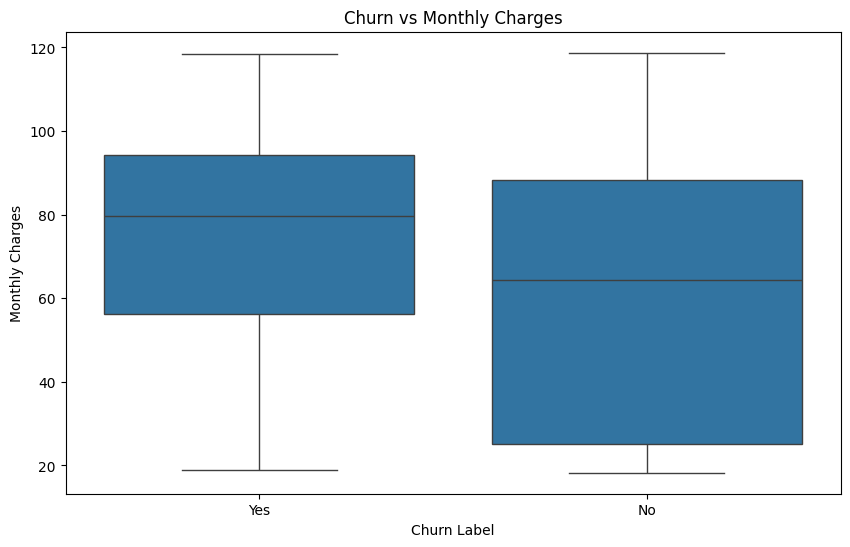

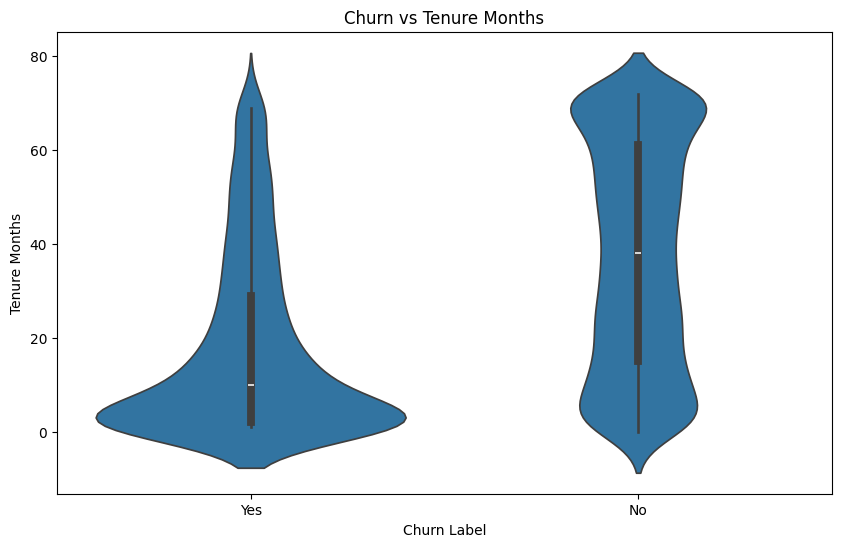

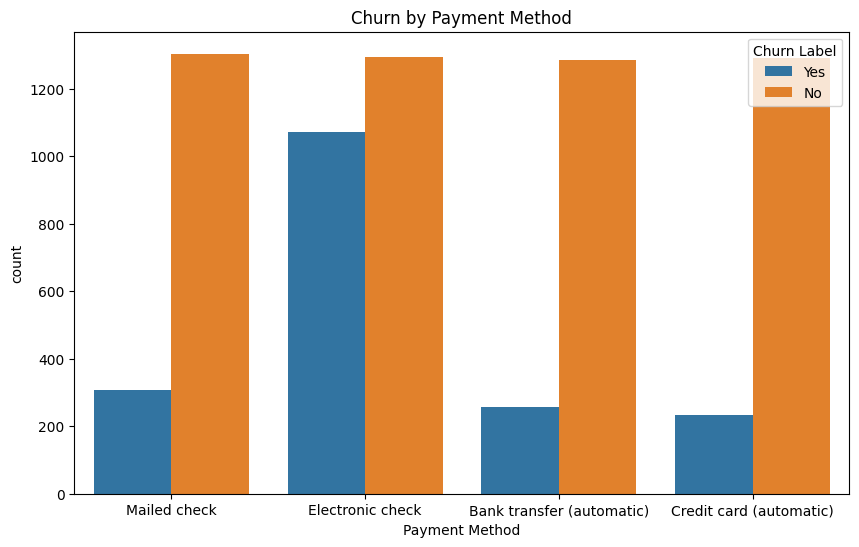

In [14]:
# Churn vs. Contract Type
plt.figure(figsize=(10, 6))
sns.countplot(x='Contract', hue='Churn Label', data=df)
plt.title('Churn by Contract Type')
plt.show()

# Churn vs. Monthly Charges (Box plot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn Label', y='Monthly Charges', data=df)
plt.title('Churn vs Monthly Charges')
plt.show()

# Churn vs. Tenure (Violin plot)
plt.figure(figsize=(10, 6))
sns.violinplot(x='Churn Label', y='Tenure Months', data=df)
plt.title('Churn vs Tenure Months')
plt.show()

# Churn vs. Payment Method
plt.figure(figsize=(10, 6))
sns.countplot(x='Payment Method', hue='Churn Label', data=df)
plt.title('Churn by Payment Method')
plt.show()


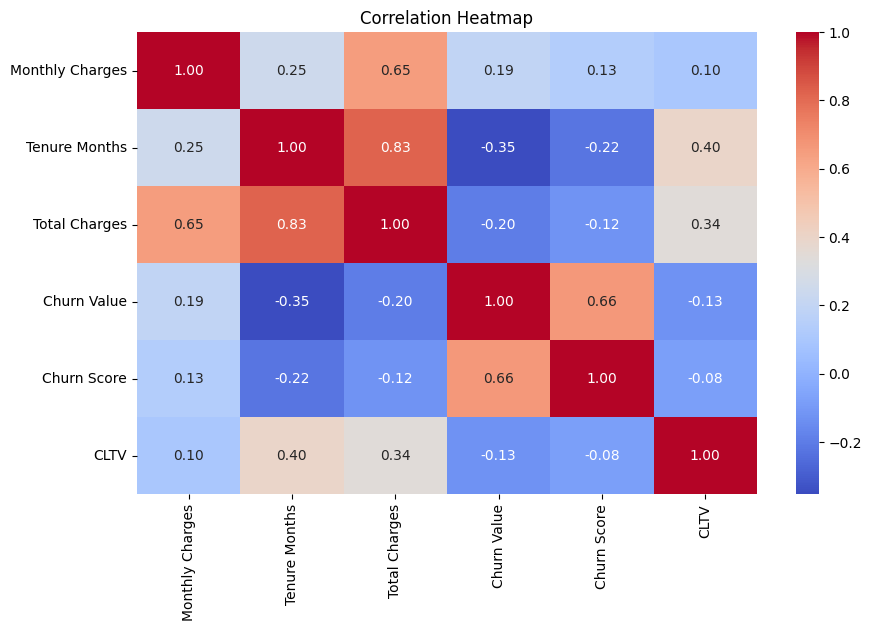

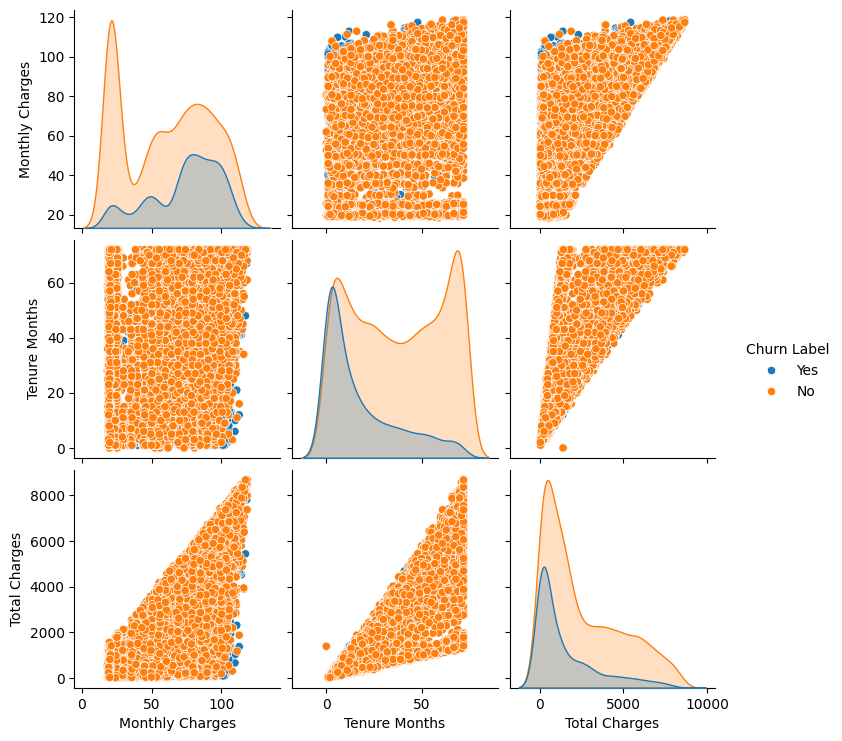

In [15]:
# Correlation heatmap for numerical features
plt.figure(figsize=(10, 6))
correlation_matrix = df[['Monthly Charges', 'Tenure Months', 'Total Charges', 'Churn Value', 'Churn Score', 'CLTV']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Pairplot for numerical features
sns.pairplot(df[['Monthly Charges', 'Tenure Months', 'Total Charges', 'Churn Label']], hue='Churn Label')
plt.show()


In [23]:
# Create new feature "MonthlySpend"
df['MonthlySpend'] = df['Total Charges'] / df['Tenure Months']

In [24]:
# Selecting only numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Compute correlation matrix for numerical columns
correlation_matrix = df[numeric_cols].corr()

# Check the correlation of 'Churn Label' with other features
target_corr = correlation_matrix['Churn Label'].sort_values(ascending=False)

print(target_corr)


KeyError: 'Churn Label'